In [1]:
import torch
from trak import TRAKer
from tqdm.auto import tqdm
from pathlib import Path
from matplotlib import pyplot as plt
from diffusion_trak import DiffusionModelOutput
from diffusion_trak import DiffusionGradientComputer
from diffusers import DDPMScheduler, StableDiffusionPipeline
from transformers import CLIPTextModel, CLIPTokenizer
from datasets import load_dataset_builder
from datasets import load_dataset
from copy import deepcopy
from numpy.lib.format import open_memmap
import numpy as np

# local imports
from utils import get_mscoco_model, get_mscoco_loader, run_mscoco_pipe
from demo_utils import load_checkpoints, load_trak_results
torch.backends.cuda.enable_mem_efficient_sdp(False)

# MS COCO text-conditional model

In [2]:
model = get_mscoco_model(sample_size=128, n_channels=4)
model.eval();

In [3]:
checkpoints = load_checkpoints('MSCOCO', root='.')
model.load_state_dict(checkpoints[0])

Models already downloaded and extracted.


<All keys matched successfully>

In [4]:
loader_train = get_mscoco_loader(20, split="train")

loading annotations into memory...
Done (t=0.48s)
creating index...
index created!


## Generate sample trajectories with DDPM

We'll now generate some samples $x_0$ by running the DDPM sampler for a thousand iterations, starting from $x_{1000}$ and iteratively denoising the batch of latent images.

In [ ]:
noise_scheduler = DDPMScheduler()
model_v = "stabilityai/stable-diffusion-2"
pipe = StableDiffusionPipeline.from_pretrained(model_v,
                                               unet=deepcopy(model),
                                               scheduler=noise_scheduler,
                                               safety_checker=None).to('cuda')

In [6]:
N = 3
captions = [
    'motorcycles on the road next to a stop sign',
    'a few giraffes next to a fence',
    'flowers in a vase'
]

# fixing the seed for reproducibility
seed = 0
generator = torch.Generator(device='cuda')
generator.manual_seed(seed)

images, x_0_hats, x_ts = run_mscoco_pipe(pipe,
                                         captions,
                                         num_inference_steps=1000,
                                         generator=generator)
trajectory = torch.stack(x_0_hats)

100%|██████████| 1000/1000 [00:24<00:00, 40.56it/s]


### The synthesized images

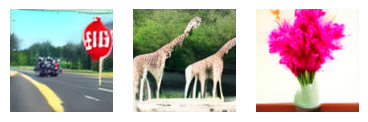

In [7]:
fig, axs = plt.subplots(nrows=1, ncols=N, figsize=(1.5 * N, 1.5))
for ii in range(N):
    axs[ii].imshow(images[ii])
    axs[ii].axis('off')
plt.show()

This is effectively the same as running the `DDPMPipeline`. We do the above in order to get access to the full trajectory of intermediate latents $x_t$, in addition to the batch of final images $x_0$.

## Attribute the sample trajectory at a timestep of choice

In [8]:
tokenizer = CLIPTokenizer.from_pretrained("stabilityai/stable-diffusion-2", subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained("stabilityai/stable-diffusion-2", subfolder="text_encoder").cuda()

In [9]:
tokens = [tokenizer(caption,
                    max_length=tokenizer.model_max_length,
                    padding="max_length",
                    truncation=True,
                    return_tensors="pt")['input_ids'].cuda()
          for caption in captions]
states = text_encoder(torch.cat(tokens))[0].unsqueeze(1)

In [10]:
load_trak_results('MSCOCO', root='.')

Models already downloaded and extracted.


In [ ]:
task = DiffusionModelOutput(conditional=True)

traker = TRAKer(model=model,
                task=task,
                gradient_computer=DiffusionGradientComputer,
                proj_dim=2048,
                train_set_size=len(loader_train.dataset),
                save_dir='./MSCOCO_trak_results',
                device='cuda')

Here we choose to set the timesteps $t=100$ and $t=500$. Thus, we feed the latents $x_{200}$ and $x_{500}$, respectively, to our `TRAKer` instance.

We also provide pre-computed scores for $t=100$ and $t=500$, so feel free to skip the remaining cells until the "Analyze scores" section

In [12]:
scores = {
    100: np.array(open_memmap('./MSCOCO_trak_results/scores/DEMO_T=100.mmap')),
    500: np.array(open_memmap('./MSCOCO_trak_results/scores/DEMO_T=500.mmap'))
}

In [13]:
scores = {}  # dictionary {timestep: scores_for_that_timestep}

In [ ]:
t = 100
exp_name = f"DEMO_T={t}"
num_resamplings = 20

timestep = torch.tensor(t)

bs = trajectory.shape[1]

for model_id in tqdm(range(len(checkpoints))):
    ckpt = checkpoints[model_id]
    traker.start_scoring_checkpoint(exp_name=exp_name, checkpoint=ckpt, model_id=model_id, num_targets=bs)

    # images, labels, tstep, n_iters
    batch = [trajectory.permute([1, 0, 2, 3, 4]).half(), states, timestep, num_resamplings]
    traker.score(batch=batch, num_samples=bs)

scores[t] = traker.finalize_scores(exp_name=exp_name, allow_skip=True)

In [ ]:
t = 500
exp_name = f"DEMO_T={t}"
num_resamplings = 20

timestep = torch.tensor(t)

bs = trajectory.shape[1]

for model_id in tqdm(range(len(checkpoints))):
    ckpt = checkpoints[model_id]
    traker.start_scoring_checkpoint(exp_name=exp_name, checkpoint=ckpt, model_id=model_id, num_targets=bs)

    # images, labels, tstep, n_iters
    batch = [trajectory.permute([1, 0, 2, 3, 4]).half(), states, timestep, num_resamplings]
    traker.score(batch=batch, num_samples=bs)

scores[t] = traker.finalize_scores(exp_name=exp_name, allow_skip=True)

# Analyze scores

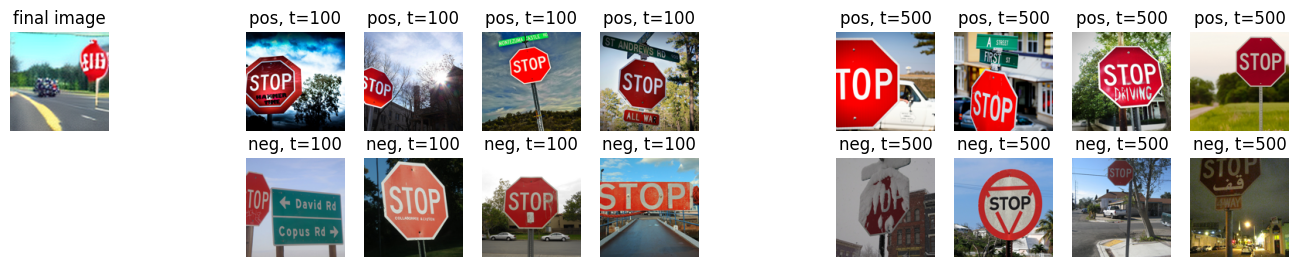

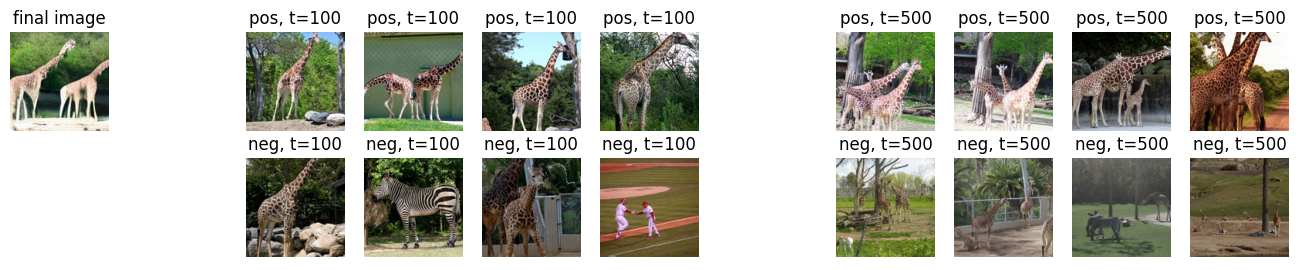

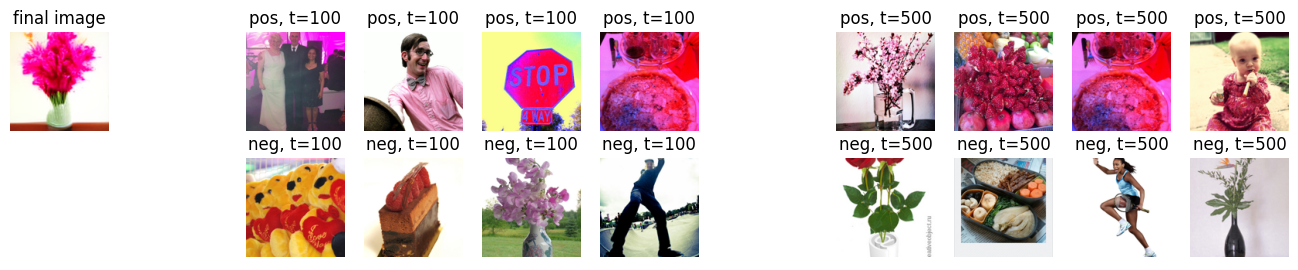

In [16]:
k = 4 # visualize the k training examples with most positive/negative TRAK scores
T = len(list(scores.keys()))
for i in range(N):
    top_inds = {}
    bot_inds = {}
    for t in scores.keys():
        top_inds[t] = torch.tensor(scores[t][:, i]).reshape(-1).argsort()[-k:].flip(dims=[0])
        bot_inds[t] = torch.tensor(scores[t][:, i]).reshape(-1).argsort()[:k]
    
    fig, axs = plt.subplots(nrows=2, ncols=T * k + 3, figsize=(1.5 * (T * k + T + 1), 3))
    for ax in axs.ravel():
        ax.set_axis_off()

    axs[0, 0].imshow(images[i])
    axs[0, 0].set_title('final image')
    
    for it, t in enumerate(scores.keys()):
        for ii in range(k):
            axs[0, ii + it * (k + 1) + 2].imshow((loader_train.dataset[top_inds[t][ii].item()][0].permute([1, 2, 0]) + 1) / 2)
            axs[0, ii + it * (k + 1) + 2].set_title(f'pos, t={t}')
            axs[1, ii + it * (k + 1) + 2].imshow((loader_train.dataset[bot_inds[t][ii].item()][0].permute([1, 2, 0]) + 1) / 2)
            axs[1, ii + it * (k + 1) + 2].set_title(f'neg, t={t}')
plt.show()